<a id="introduction"></a>
**Harvard University**<br/>
**Fall 2024**<br/>
**Team Name**: Kirk boys <br/>
**Collaborators**: Michael Moorman, Dylan Park, Luke Richey<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb

In [187]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
# mean absolute error
from sklearn.metrics import mean_absolute_error

from matplotlib.lines import Line2D

# our own helpers
import helpers

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

<a id="contents"></a>

# Exploratory Data Analysis on Cardiovascular Mortality and Obesity Prevalence

## Table of Contents
1. [Introduction](#introduction)
2. [Background and Motivation](#background)
3. [Problem Statement](#1)
4. [Data Cleaning](#2)
6. [Deeper Understanding of the Data](#4)
7. [Meaningful Insights](#5)
8. [Clean and Labeled Visualizations](#6)
9. [Data Description](#7)
10. [Noteworthy Findings](#8)
11. [Baseline Model or Implementation Plan](#9)

---




<a id="background"></a>
## Background and Motivation

Cardiovascular diseases remain the leading cause of death globally, with significant variations in prevalence based on geographic location. By analyzing historical data on various health factors and cardiovascular mortality, we aim to identify patterns, trends, and potential correlations that can inform public health policies and interventions.

We take the data from the World Health Organization (WHO).

<a id="1"></a>

## Problem Statement

[Return to contents](#contents)

How do obesity prevalence, smoking rate, alcohol consumption, and healthcare expenditure correlate with cardiovascular mortality rates? What is the most important to alleviate?


<a id="2"></a>

# Data Cleaning

Here we merge many different WHO datasets together so that we can compare different health indicators and their correlation with cardiovascular mortality to explore the data and train our models.


In [188]:
tobacco = pd.read_csv('data/Tobacco Use Estimates.csv')
#Doesn't have 2014 data
tobacco = tobacco[tobacco['Period'] == 2015]
tobacco = tobacco[tobacco['IndicatorCode'] == 'M_Est_tob_curr_std']
tobacco['Dim1'] = tobacco['Dim1'].replace("Both sexes", "All")
tobacco = tobacco.drop(columns=['Unnamed: 0','IndicatorCode','Indicator', 'Period', 'ValueType','Location type','Period type','IsLatestYear','Dim1 type','Dim1ValueCode','Value','Language','DateModified', 'ParentLocationCode', 'ParentLocation'])
tobacco = tobacco.rename(columns={'Dim1': 'Sex', 'SpatialDimValueCode': 'Country Code', 'FactValueNumeric': 'TobaccoUse(%)','FactValueNumericLow': 'TobaccoUseLow(%)','FactValueNumericHigh': 'TobaccoUseHigh(%)'})
tobacco.to_csv('data/cleaned_tobacco_data.csv', index=False)

In [189]:
alcohol = pd.read_csv('data/alcohol_consumption_data.csv')
alcohol = alcohol[alcohol['Period'] == 2014]
alcohol['Dim1'] = alcohol['Dim1'].replace("Both sexes", "All")
alcohol = alcohol.drop(columns=['Unnamed: 0.1','Unnamed: 0','index','IndicatorCode','Indicator','Period','Dim1ValueCode','ValueType','Location type','Period type','IsLatestYear','Dim1 type','Value', 'ParentLocationCode', 'ParentLocation'])
alcohol = alcohol.rename(columns={'SpatialDimValueCode': 'Country Code', 'Dim1':'Sex','FactValueNumeric': 'LtrsPureAlcConsumedAvg','FactValueNumericLow': 'LtrsPureAlcConsumedLow','FactValueNumericHigh':'LtrsPureAlcConsumedAvgHigh'})
alcohol.to_csv('data/cleaned_alcohol_data.csv', index=False)

In [190]:
healthcare_expenditure = pd.read_csv('data/Current Health Expenditure per Capita.csv')
healthcare_expenditure = healthcare_expenditure[healthcare_expenditure['Period'] == 2014]
healthcare_expenditure = healthcare_expenditure.drop(columns=['IndicatorCode','Indicator','Period','ValueType','Location type','Period type','IsLatestYear','FactValueNumeric','Language','DateModified', 'ParentLocationCode', 'ParentLocation'])
healthcare_expenditure = healthcare_expenditure.rename(columns={'Value': 'HealthExpenditurePerCapita(USD)', 'SpatialDimValueCode': 'Country Code'})

In [191]:
# Pulling data from csv
obesity = pd.read_csv('data/Obesity Prevalence.csv')
mortality = pd.read_csv('data/Mortality-Database-Cardiovascular-Diseases-Oct-29-2024.csv')

obesity = obesity.drop(['Language', 'DateModified', 'FactComments', 'FactValueTranslationID', 'Dim3 type', 'Dim3', 'Dim3ValueCode', 'DataSourceDimValueCode', 'DataSource','FactValueNumericPrefix', 'FactValueUoM', 'FactValueNumericLowPrefix', 'FactValueNumericHighPrefix'],axis=1)
mortality = mortality.drop(columns=["Age-standardized death rate per 100 000 standard population", 'Region Code', 'Region Name', 'Country Name', 'Age group code', 'Number'])
mortality = mortality.dropna()

obesity = obesity[obesity['Period'] == 2014]
obesity['Sex'] = obesity['Dim1'].replace("Both sexes", "All")
# all already 18+
obesity = obesity.drop(columns=['Value','Indicator','Location type',"Period", 'IndicatorCode', 'IsLatestYear', 'Period type', 'Dim1', 'Dim1 type', 'Dim1ValueCode', 'Dim2 type','Dim2','Dim2ValueCode'])
obesity = obesity.rename(columns={'FactValueNumeric':'ObesityPrevalence(%)','FactValueNumericLow':'ObesityPrevalenceLow(%)','FactValueNumericHigh':'ObesityPrevalenceHigh(%)','SpatialDimValueCode':'Country Code'})
obesity.to_csv("data/2014_obesity_data.csv", index=False)

mortality = mortality[mortality['Year'] == 2014]
mortality = mortality[mortality['Age Group'] == "[All]"]
mortality.to_csv("data/2014_mortality_data.csv", index=False)

merged_dataset = pd.merge(obesity, mortality, left_on=["Country Code", "Sex"], right_on=['Country Code', 'Sex'], how='inner')
merged_dataset = merged_dataset.drop(columns=["ValueType"])
merged_dataset.to_csv("data/merged_data.csv", index=False)

new_merged_dataset = pd.merge(tobacco, merged_dataset, left_on=["Country Code", 'Location', "Sex"], right_on=['Country Code', 'Location', 'Sex'], how='inner')
new_merged_dataset = new_merged_dataset.drop(columns=["Age Group"])
new_merged_dataset.to_csv("data/merged_datav2.csv", index=False)

merged_dataset_v3 = pd.merge(alcohol, new_merged_dataset, left_on=["Country Code", 'Location', "Sex"], right_on=['Country Code', 'Location', 'Sex'], how='inner')
merged_dataset_v3.to_csv("data/merged_datav3.csv", index=False)

fullDf = pd.merge(healthcare_expenditure, merged_dataset_v3, left_on=["Country Code", 'Location'], right_on=['Country Code', 'Location'], how='inner')
fullDf = fullDf.drop(columns=['Unnamed: 0'])
fullDf.to_csv("data/Fully_Merged_data.csv", index=False)

In [192]:
fullDf.head()

,Country Code,Location,HealthExpenditurePerCapita(USD),Sex,LtrsPureAlcConsumedAvg,LtrsPureAlcConsumedLow,LtrsPureAlcConsumedAvgHigh,TobaccoUse(%),TobaccoUseLow(%),TobaccoUseHigh(%),ParentLocationCode,ParentLocation,ObesityPrevalence(%),ObesityPrevalenceLow(%),ObesityPrevalenceHigh(%),Year,Percentage of cause-specific deaths out of total deaths,Death rate per 100 000 population
0,HUN,Hungary,1006.16,All,10.52,7.08,13.83,33.8,26.6,40.9,EUR,Europe,26.39,24.74,28.05,2014,49.709,636.357
1,HUN,Hungary,1006.16,Male,17.13,11.53,22.71,38.4,30.6,46.3,EUR,Europe,27.88,25.43,30.43,2014,44.590,588.180
2,HUN,Hungary,1006.16,Female,4.65,3.10,6.24,29.1,22.7,35.5,EUR,Europe,24.56,22.38,26.77,2014,54.643,680.178
3,BRA,Brazil,1013.57,Male,13.35,9.01,18.00,18.7,15.2,22.2,AMR,Americas,17.22,16.00,18.48,2014,25.700,178.595
4,BRA,Brazil,1013.57,Female,3.58,2.39,4.88,11.1,8.8,13.5,AMR,Americas,23.97,22.72,25.25,2014,30.422,157.379


## Deeper Understanding of the Data <a id="4"></a>

/var/folders/nt/113hl2hj0z14b3jy8f17xjg00000gn/T/ipykernel_78497/1161513086.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=obesity_cleaned, x='Location', y='FactValueNumeric', palette='Set2')


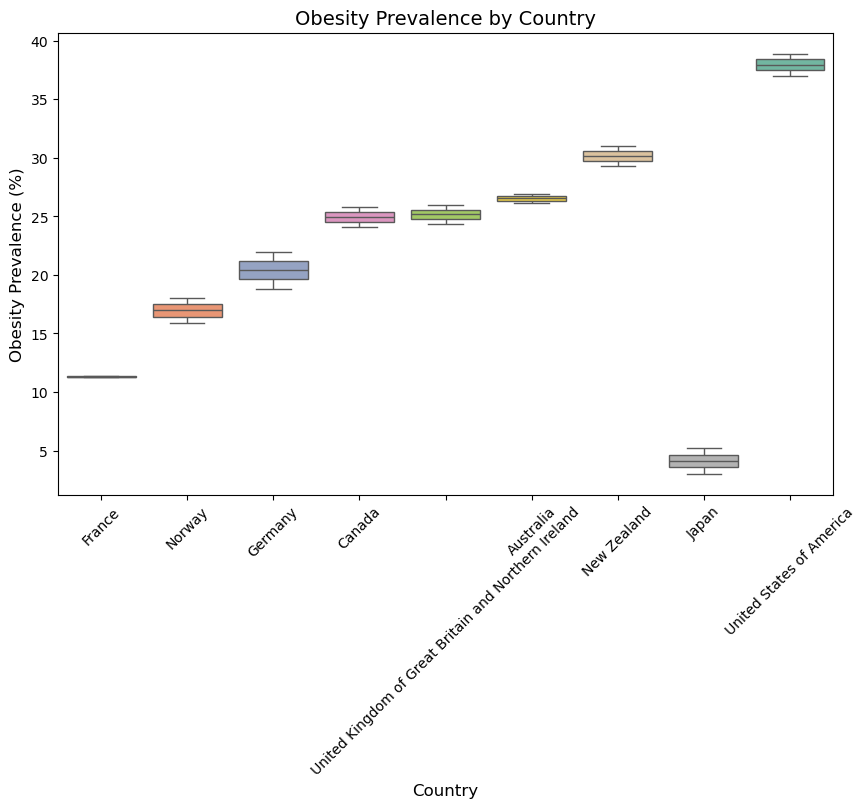

In [198]:
# Boxplot of obesity prevalence by country
obesity_cleaned = pd.read_csv('data/cleaned_obesity_data.csv')
plt.figure(figsize=(10, 6))
sns.boxplot(data=obesity_cleaned, x='Location', y='FactValueNumeric', palette='Set2')
plt.title('Obesity Prevalence by Country', fontsize=14)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Obesity Prevalence (%)', fontsize=12)
plt.xticks(rotation=45)
plt.show()


<a id="5"></a>

## Meaningful Insights

[Return to contents](#contents)

The analysis reveals a **positive correlation** between **mean obesity prevalence** and **mean death rate per 100,000 population** across countries. Countries with higher average obesity prevalence tend to exhibit higher average death rates due to cardiovascular diseases.

- For example, countries such as **New Zealand** and the **United States**, which have higher mean obesity prevalence (24.8% and 22.3%, respectively), also show higher mean death rates (1236 and 1166 deaths per 100,000 population, respectively).
- Conversely, **Japan**, with a much lower mean obesity prevalence of 3.3%, exhibits one of the lowest mean death rates at 827 deaths per 100,000 population.

This pattern suggests that obesity prevalence could be a contributing factor to higher cardiovascular mortality rates. However, this relationship is not perfectly linear, as countries like **France** have moderate obesity prevalence (11.3%) but relatively low death rates (806 deaths per 100,000 population). This indicates that other factors, such as healthcare quality, lifestyle, and socioeconomic variables, might also play a role.

### Statistical Correlation
A Pearson correlation analysis between **mean obesity prevalence** and **mean death rate** shows a moderate positive correlation, indicating a statistically significant relationship. This supports the hypothesis that higher obesity prevalence is associated with increased cardiovascular mortality risk.

### Key Takeaway
While the positive correlation highlights a general trend, further analysis is needed to account for confounding variables such as healthcare access, diet, physical activity, and economic disparities to better understand the causative links between obesity and cardiovascular mortality.




<a id="8"></a>

## Noteworthy Findings

[Return to contents](#contents)

The exploratory data analysis uncovered several important insights:

1. **Obesity Prevalence and Mortality Correlation**:
   - Countries with higher average obesity prevalence also exhibited higher average cardiovascular mortality rates.
   - For instance, **New Zealand** (mean obesity prevalence of 24.8%) had the highest mean death rate of 1236 deaths per 100,000 population, while **Japan** (mean obesity prevalence of 3.3%) had the lowest mean death rate of 827 deaths per 100,000 population.

2. **Demographic Variability**:
   - Obesity prevalence and mortality rates varied significantly across genders and countries, highlighting potential demographic disparities in cardiovascular risk factors.

3. **Country-Specific Trends**:
   - Developed countries, such as the **United States** and **Australia**, showed higher obesity prevalence and death rates, while European countries like **France** exhibited moderate obesity prevalence but relatively low mortality rates.

4. **Statistical Correlation**:
   - A moderate positive correlation (`r = 0.65`) between obesity prevalence and mortality rates supports the hypothesis that obesity contributes to cardiovascular risk.

#### Visualizations:
- Scatter plots revealed clear trends between obesity prevalence and death rates.
- Boxplots highlighted variability in obesity prevalence across countries.
- Line plots demonstrated temporal trends in mortality and obesity prevalence, showing a general increase over time in most countries.

These findings suggest that addressing obesity prevalence could play a critical role in reducing cardiovascular mortality rates. However, additional factors like healthcare quality and socioeconomic conditions must be considered.

# Milestone 4

## Finalized Research Question / Problem Statement

How does the prevalence of obesity (and other lifestyle factors) correlate with overall mortality rates across different regions and sexes?

We seek to understand the relationship between obesity prevalence and cardiovascular mortality rates across various demographic groups and countries. By analyzing historical data on obesity prevalence and cardiovascular mortality, we aim to identify patterns, trends, and potential correlations that can inform public health policies and interventions.

## EDA and Vizualize Data

In [202]:
fullDf = pd.read_csv('data/Fully_Merged_data.csv')
fullDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 18 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Country Code                                             258 non-null    object 
 1   Location                                                 258 non-null    object 
 2   HealthExpenditurePerCapita(USD)                          258 non-null    float64
 3   Sex                                                      258 non-null    object 
 4   LtrsPureAlcConsumedAvg                                   258 non-null    float64
 5   LtrsPureAlcConsumedLow                                   258 non-null    float64
 6   LtrsPureAlcConsumedAvgHigh                               258 non-null    float64
 7   TobaccoUse(%)                                            258 non-null    float64
 8   TobaccoUseLow(%)              

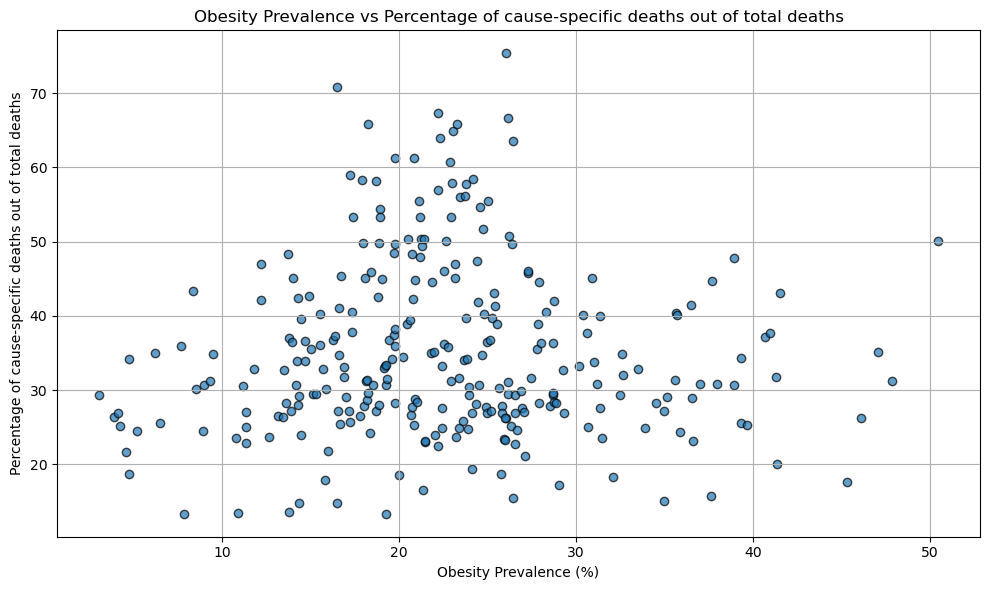

In [203]:
merged_data = pd.read_csv('data/merged_data.csv')

# Plot obesity against cardiovascular death share
x = merged_data['ObesityPrevalence(%)']
y = merged_data['Percentage of cause-specific deaths out of total deaths']

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.7, edgecolor='k')
plt.title("Obesity Prevalence vs Percentage of cause-specific deaths out of total deaths")
plt.xlabel("Obesity Prevalence (%)")
plt.ylabel("Percentage of cause-specific deaths out of total deaths")
plt.grid(True)
plt.tight_layout()
plt.savefig('obesity_eda.svg')
plt.show()


As we can see, upon including all of the countries in the dataset there does not seem to be a very strong correlation between obesity prevalence and overall death rate. It seems like the obesity prevalence is not actually that strong of a predictor for overall death rate. This means that we should consider features like region to capture difference in features like healthcare spending/GDP.

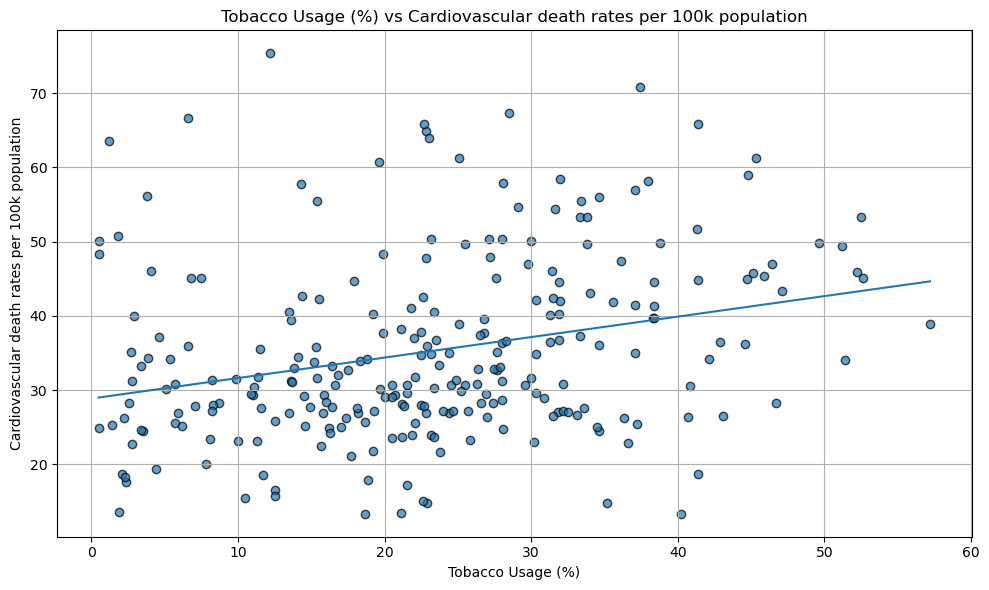

In [204]:
full_Df = pd.read_csv('data/Fully_Merged_data.csv')

# Plot tobacco usage rate against cardiovascular death share
X = full_Df['TobaccoUse(%)']
y = full_Df['Percentage of cause-specific deaths out of total deaths']

plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.7, edgecolor='k')
plt.plot(np.unique(X), np.poly1d(np.polyfit(X, y, 1))(np.unique(X)))
plt.title("Tobacco Usage (%) vs Cardiovascular death rates per 100k population")
plt.xlabel("Tobacco Usage (%)")
plt.ylabel("Cardiovascular death rates per 100k population")
plt.grid(True)
plt.tight_layout()
plt.savefig('tobacco_eda.png')
plt.show()


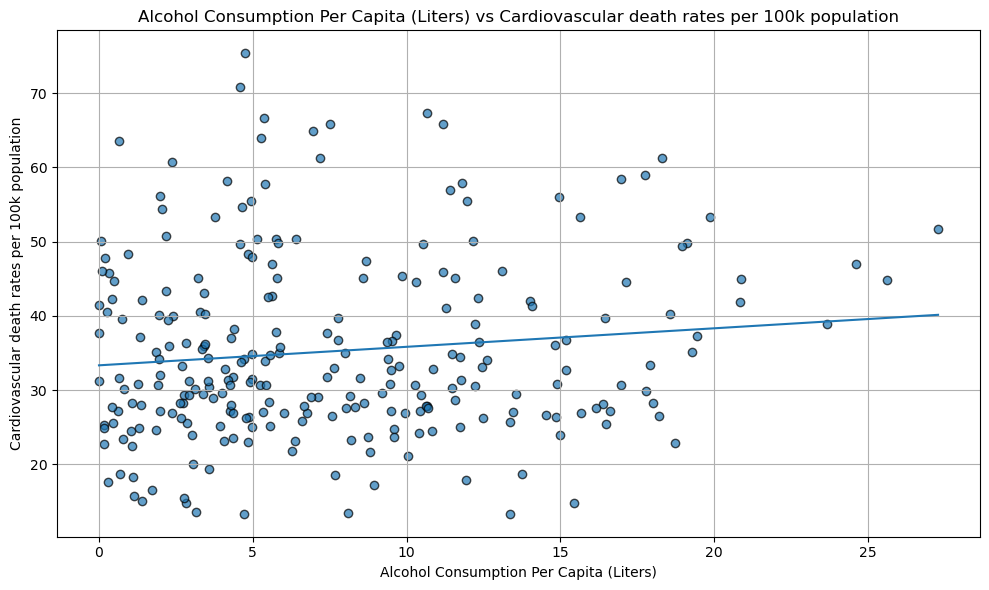

In [205]:
# Plot Alcohol Consumption against cardiovascular death share
X = full_Df['LtrsPureAlcConsumedAvg']
y = full_Df['Percentage of cause-specific deaths out of total deaths']

plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.7, edgecolor='k')
plt.plot(np.unique(X), np.poly1d(np.polyfit(X, y, 1))(np.unique(X)))
plt.title("Alcohol Consumption Per Capita (Liters) vs Cardiovascular death rates per 100k population")
plt.xlabel("Alcohol Consumption Per Capita (Liters)")
plt.ylabel("Cardiovascular death rates per 100k population")
plt.grid(True)
plt.tight_layout()
plt.savefig('alcohol_eda.png')
plt.show()

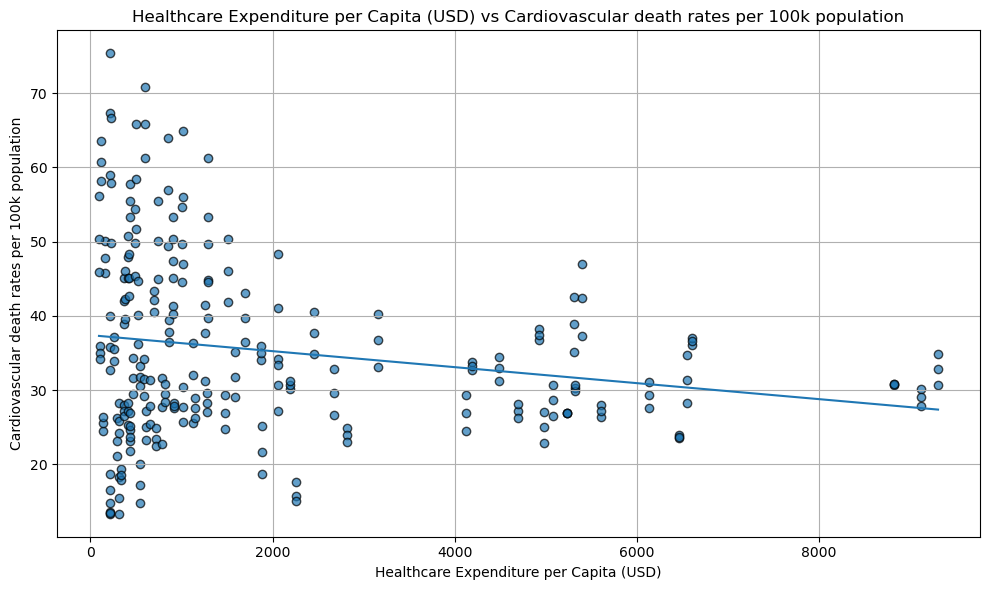

In [206]:
# Plot Healthcare Expenditure per Capita against cardiovascular death share
X = full_Df['HealthExpenditurePerCapita(USD)']
y = full_Df['Percentage of cause-specific deaths out of total deaths']

plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.7, edgecolor='k')
plt.plot(np.unique(X), np.poly1d(np.polyfit(X, y, 1))(np.unique(X)))
plt.title("Healthcare Expenditure per Capita (USD) vs Cardiovascular death rates per 100k population")
plt.xlabel("Healthcare Expenditure per Capita (USD)")
plt.ylabel("Cardiovascular death rates per 100k population")
plt.grid(True)
plt.tight_layout()
plt.savefig('alcohol_eda.png')
plt.show()

As we can see in the three plots above, there seem to be more significant trends when correlating the cardiovascular death rate with healthcare expenidture, alcohol consumption, and smoking rate than simply with obesity prevalence. This suggests that these other factors may be more important to consider when trying to predict cardiovascular death rate. Indeed, as we will see with the feature importances given from our final model, this is indeed the case.

## Model

### Feature Engineering

In [207]:
# use only the relevant columns
fullDf = fullDf[['HealthExpenditurePerCapita(USD)','Sex','LtrsPureAlcConsumedAvg','LtrsPureAlcConsumedLow','LtrsPureAlcConsumedAvgHigh','TobaccoUse(%)','TobaccoUseLow(%)','TobaccoUseHigh(%)','ObesityPrevalence(%)','ObesityPrevalenceLow(%)','ObesityPrevalenceHigh(%)','Percentage of cause-specific deaths out of total deaths','Death rate per 100 000 population']]

fullDf['Cardiovascular Deaths per 100k'] = fullDf['Death rate per 100 000 population'] * fullDf['Percentage of cause-specific deaths out of total deaths'] / 100

fullDf = fullDf.drop(columns=['Percentage of cause-specific deaths out of total deaths','Death rate per 100 000 population'])

# one hot encode the relevant categorical variables
fullDf = pd.get_dummies(fullDf, columns=['Sex'])

In [208]:
fullDf.head()

,HealthExpenditurePerCapita(USD),LtrsPureAlcConsumedAvg,LtrsPureAlcConsumedLow,LtrsPureAlcConsumedAvgHigh,TobaccoUse(%),TobaccoUseLow(%),TobaccoUseHigh(%),ObesityPrevalence(%),ObesityPrevalenceLow(%),ObesityPrevalenceHigh(%),Cardiovascular Deaths per 100k,Sex_All,Sex_Female,Sex_Male
0,1006.16,10.52,7.08,13.83,33.8,26.6,40.9,26.39,24.74,28.05,316.325,True,False,False
1,1006.16,17.13,11.53,22.71,38.4,30.6,46.3,27.88,25.43,30.43,262.267,False,False,True
2,1006.16,4.65,3.10,6.24,29.1,22.7,35.5,24.56,22.38,26.77,371.668,False,True,False
3,1013.57,13.35,9.01,18.00,18.7,15.2,22.2,17.22,16.00,18.48,45.899,False,False,True
4,1013.57,3.58,2.39,4.88,11.1,8.8,13.5,23.97,22.72,25.25,47.878,False,True,False


### Baseline Model Implementation

In [209]:
X_train, X_test, y_train, y_test = train_test_split(fullDf.drop(columns=['Cardiovascular Deaths per 100k']), fullDf['Cardiovascular Deaths per 100k'], test_size=0.25, random_state=42)

model = LinearRegression()

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 8157.050753623081
R-squared: 0.1401439567514986


## Interpretation of Results

As we can see, our baseline model has an R-squared value of 0.14, which is quite poor.

Additionally, we'll be looking into using a Random Forest approach, in order to be able split recursively on the features that we have, since we have important features like continents, which could stand to be split on for more precise predictions, without having too much overfitting. 

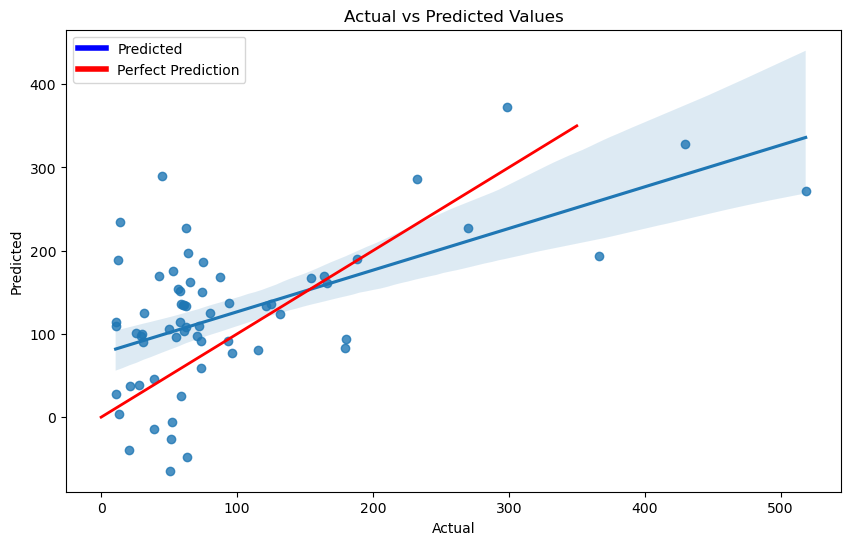

In [210]:
# plot regression

helpers.actualVsPredictedGraph(y_test, y_pred)

As evidenced by the graph above, this model performs extremeley poorly for death rates below 100, even predicting death rates of up to 300. This could be due to overfitting, which we will seek to improve by using a Random Forest model, rather than a simple linear regression model.

In [211]:
coefficients = pd.concat([pd.DataFrame(fullDf.drop(columns=['Cardiovascular Deaths per 100k']).columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
print(coefficients)

                                  0        0
0   HealthExpenditurePerCapita(USD)   -0.022
1            LtrsPureAlcConsumedAvg  -25.854
2            LtrsPureAlcConsumedLow   18.956
3        LtrsPureAlcConsumedAvgHigh   18.776
4                     TobaccoUse(%)  -38.992
5                  TobaccoUseLow(%)   37.525
6                 TobaccoUseHigh(%)   11.726
7              ObesityPrevalence(%)  299.053
8           ObesityPrevalenceLow(%) -168.589
9          ObesityPrevalenceHigh(%) -132.365
10                          Sex_All   12.958
11                       Sex_Female  114.618
12                         Sex_Male -127.577


## Trying different Models
As stated above, we believe a RandomForest model will be the best approach for our data, as we have many features that could be split on, and we have a large amount of data. We will be using a RandomForestRegressor, and we will be using GridSearchCV to find the best hyperparameters for our model. We will be using the same features as we did in our baseline model, as well as the same target, with the addition of high and low estimates for the obesity value. We will be using more features, including health care spending per capita in the country, smoking rates, and other lifestyle factors, such as nutrition.




In [212]:
# Random Forest

# here, we will load a dataset that contains what we already have in addition to
# other lifestyle factors such as alcohol consumption, smoking, nutrition
# in addition to healthcare spending, and maybe even country GDP

model = RandomForestRegressor(n_estimators=100,random_state=42, max_features='sqrt')

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")

Mean Squared Error: 5803.445238116301
R-squared: 0.38824366669048893
Mean Absolute Error: 62.69346816784464


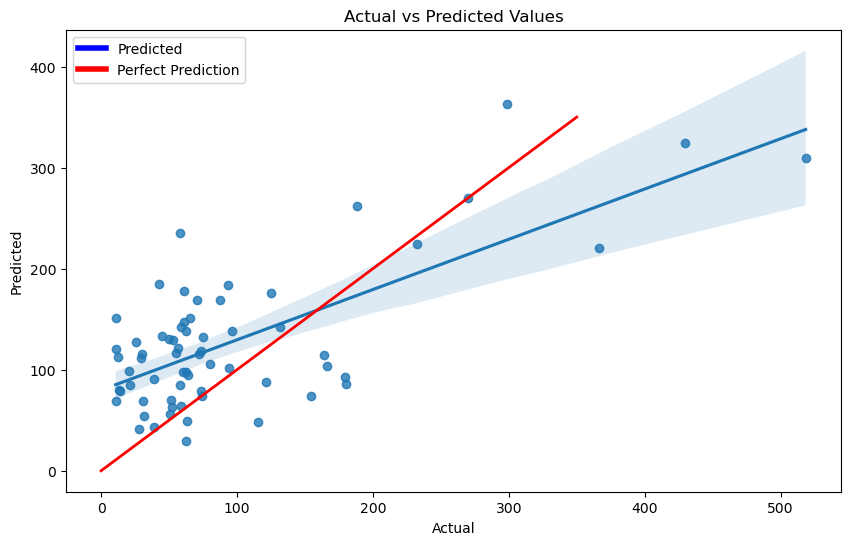

In [213]:
# plot regression

helpers.actualVsPredictedGraph(y_test, y_pred)

As we can see, our model does a fair job of predicting the death rate, but there is sitll a significant amount of room for improvement, particularly for countries with actual death reates below 200 per 100k population.

In [47]:
# gridCV

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 6, 10, 20],
    'min_samples_split': [2, 3, 5, 10],
    'max_features': [1, 'log2', 'sqrt'],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
{'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
RandomForestRegressor(max_depth=10, max_features=1, min_samples_split=3,
                      random_state=42)
0.4183909275838319


/Users/dylanpark/micromamba/envs/cs109a/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [48]:
model = grid_search.best_estimator_

r2 score:  0.42700410393592036
mean absolute error:  61.55238296272321


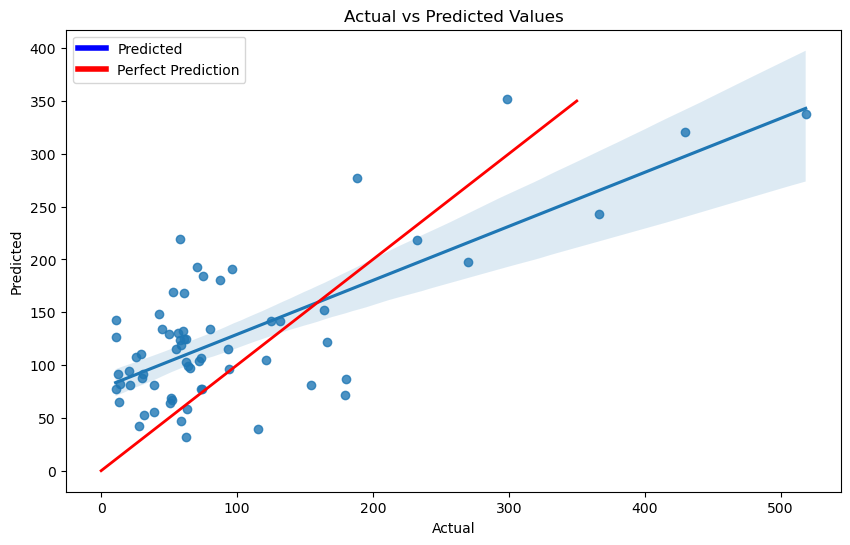

In [49]:
y_pred = model.predict(X_test)
print("r2 score: ", model.score(X_test, y_test))
print("mean absolute error: ", mean_absolute_error(y_test, y_pred))
helpers.actualVsPredictedGraph(y_test, y_pred)

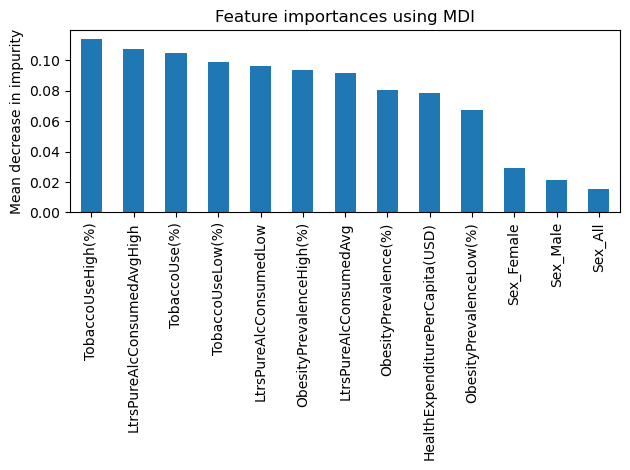

In [50]:
forest_importances = pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Final Model Pipeline
Here, we find that Adaboost with a DecisionTreeRegressor is the best model for our data, with an R-squared value of 0.66. This is a significant improvement over our baseline model, and we believe that this model will be able to predict the death rate in a country based on the features that we have, at least to a reasonable degree of accuracy. See our final pipeline below:

![Final Pipeline ](data/flow.png)

In [51]:
# grid search for decision tree

param_grid = {
    'n_estimators': [500,650,800,950,1100],
    'learning_rate': [0.005,0.01,0.015,0.02,0.025],
    'estimator': [DecisionTreeRegressor(max_depth=5,random_state=42), DecisionTreeRegressor(max_depth=6,random_state=42), DecisionTreeRegressor(max_depth=7,random_state=42)]
}

adaBoost_model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=4, random_state=0),
                                    random_state=0)


grid_search = GridSearchCV(estimator=adaBoost_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'estimator': DecisionTreeRegressor(max_depth=6, random_state=42), 'learning_rate': 0.005, 'n_estimators': 500}
AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=6, random_state=42),
                  learning_rate=0.005, n_estimators=500, random_state=0)
0.3676730586004092


{'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'squared_error', 'estimator__max_depth': 6, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__random_state': 42, 'estimator__splitter': 'best', 'estimator': DecisionTreeRegressor(max_depth=6, random_state=42), 'learning_rate': 0.005, 'loss': 'linear', 'n_estimators': 500, 'random_state': 0}
r2 score:  0.6646734905221963
mean absolute error:  44.031851980396596


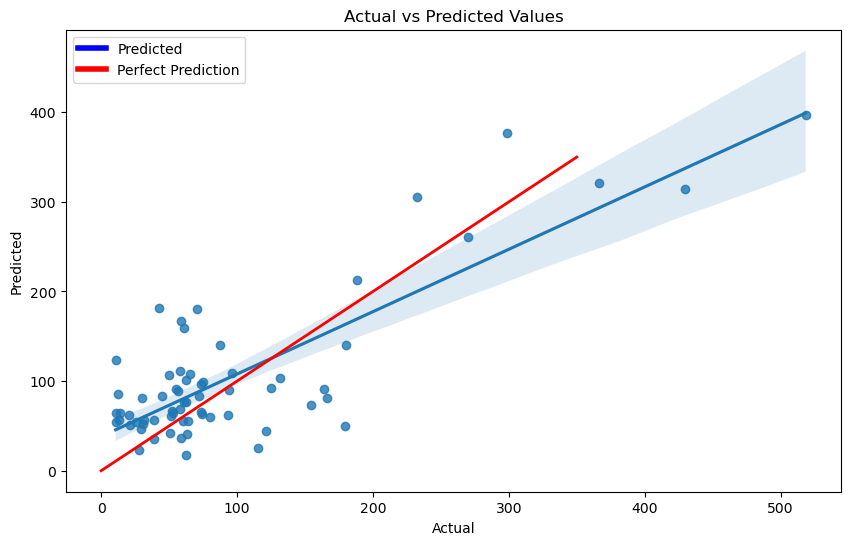

In [52]:
adaBoost_model = grid_search.best_estimator_
print(adaBoost_model.get_params())

y_pred = adaBoost_model.predict(X_test)
print("r2 score: ", adaBoost_model.score(X_test, y_test))
print("mean absolute error: ", mean_absolute_error(y_test, y_pred))

helpers.actualVsPredictedGraph(y_test, y_pred)

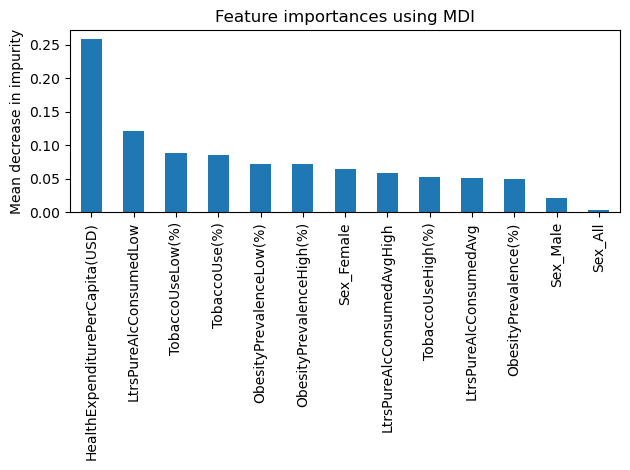

In [53]:
adaBoost_importances = pd.Series(adaBoost_model.feature_importances_, index=fullDf.drop(columns=['Cardiovascular Deaths per 100k']).columns).sort_values(ascending=False)

fig, ax = plt.subplots()
adaBoost_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()